# Food and Optimizers


Suppose we are given a classification task of determining if a food item is healthy or not. This task would bring a lot of values to people who need diet management such as diabetic patients.


Each food item has nutrition information per serving such as its carbohydrates, fat, fibers, vitamins, etc. We know that for unhealthy food items such as fried chicken, we should choose less frequently in our daily diet and for healthy food items such as salad without sauce, we should chooose them more often in our diet. Now given the complexity of the problem, we plan to use ML algorithms such as Neural Networks to classify those food items.


However, the first neural network you trained had pretty bad performance and essentially underfits the dataset. As a data scientist, you know the performance may be caused by many factors such as bad data quality, architecture of your neural network, non-optimized hyperparameter tuning, etc. So you tried them all and the model result still looks pretty bad. 


We will see different optimizers could also play a big role in neural network training process.


## Objectives


* Explain several popular optimizers
* Evaluate their performance in a real-world classification scenario


----


In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random


### Load and explore the dataset


In [2]:
food_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/food_items.csv")

Let's quickly take a look at the dataset:


In [3]:
food_df.shape

(13260, 18)

As we can see, it has 13260 data instances and 18 columns (features + label):


In [4]:
food_df.head()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron,class
0,149.0,0,0.0,0.0,0.0,0.0,0,9.0,9.8,0.0,0.0,0,1.3,0,0,0,0,'In Moderation'
1,123.0,0,0.0,0.0,0.0,0.0,0,5.0,6.6,0.0,0.0,0,0.8,0,0,0,0,'In Moderation'
2,150.0,0,0.0,0.0,0.0,0.0,0,4.0,11.4,0.0,0.0,0,1.3,0,0,0,0,'In Moderation'
3,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0,'In Moderation'
4,143.0,0,0.0,0.0,0.0,0.0,0,7.0,13.1,0.0,0.0,0,1.0,0,0,0,0,'In Moderation'


In [5]:
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13260 entries, 0 to 13259
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Calories             13260 non-null  float64
 1   Total Fat            13260 non-null  int64  
 2   Saturated Fat        13260 non-null  float64
 3   Monounsaturated Fat  13260 non-null  float64
 4   Polyunsaturated Fat  13260 non-null  float64
 5   Trans Fat            13260 non-null  float64
 6   Cholesterol          13260 non-null  int64  
 7   Sodium               13260 non-null  float64
 8   Total Carbohydrate   13260 non-null  float64
 9   Dietary Fiber        13260 non-null  float64
 10  Sugars               13260 non-null  float64
 11  Sugar Alcohol        13260 non-null  int64  
 12  Protein              13260 non-null  float64
 13  Vitamin A            13260 non-null  int64  
 14  Vitamin C            13260 non-null  int64  
 15  Calcium              13260 non-null 

More features are about the nutritions of a specific food items. Then let's check the target variable, i.e., the `class` column:


<Axes: xlabel='class'>

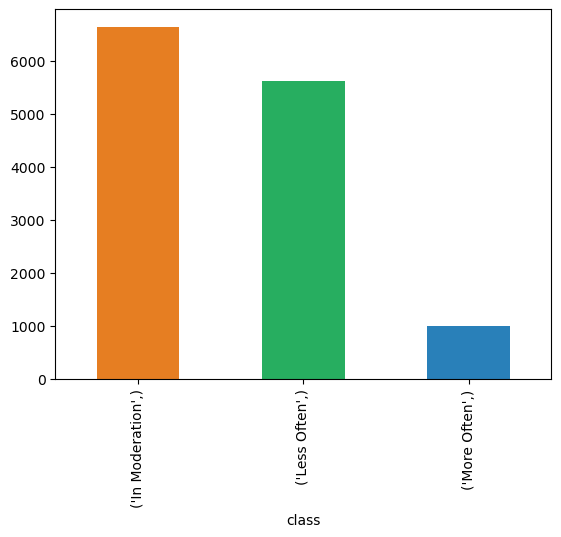

In [6]:
# # Get the row entries with the last col 'class'
food_df.iloc[:, -1:].value_counts(normalize=True)
food_df.iloc[:, -1:].value_counts().plot.bar(color=['#e67e22', '#27ae60', '#2980b9'])

The target variable indicates how often we should include this food item in our diet, and it has three classes `In Moderation`, `Less Often`, `More Often`. It indicates that this is a multi-class classification task and the class distribution is a little bit imbalanced.


## Data processing


Then, let's quickly process the dataset:


First split the features `X` (the input) and labels `y` (the output)


In [7]:
X_raw = food_df.iloc[:, :-1]
y_raw = food_df.iloc[:, -1:]

Then normalize the `X`:


In [8]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Scaling the raw input features
X = scaler.fit_transform(X_raw)

and encode the target variable:


In [9]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

Finally we can split the dataset into training and testing datasets, and we're ready to train a neural network.


In [10]:
rs = 123 # set random state

In [11]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (10608, 17), y_train: (10608,)
Testing dataset shape, X_test: (2652, 17), y_test: (2652,)


## Firstly we try a logistic regression as our baseline

In [12]:
# Define a logistic regression model with above arguments
lr_model = LogisticRegression(random_state=rs, max_iter = 200)
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print(f"The test score for the logistic regression is {round(lr_score, 2)}")

The test score for the logistic regression is 0.77


## Train a RandomForrest model

Now we can try to improve our model trying a RandomForrest model.

In [13]:
cv_params = {'max_depth':[2,4,8,None],
             'min_samples_leaf':[1,2,4],
             'min_samples_split':[2,4],
             'max_features':[2,4,6],
             'n_estimators':[50,100,200]}

rf = RandomForestClassifier(random_state = rs)

scoring = {'accuracy','precision','recall','f1'}

rf_cv = RandomizedSearchCV(rf,cv_params,cv=5,refit='f1')

rf_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                   param_distributions={'max_depth': [2, 4, 8, None],
                                        'max_features': [2, 4, 6],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [50, 100, 200]},
                   refit='f1')

In [14]:
print('RandomForrest best params',rf_cv.best_params_)
print(f"RandomForrest training score {round(rf_cv.best_score_, 2)}")

rf_score = rf_cv.score(X_test, y_test)
print(f"The test score for the RandomForest is {round(rf_score, 2)}")

RandomForrest best params {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': None}
RandomForrest training score 0.93
The test score for the RandomForest is 0.94


Here we see that RandomForrest outperforms logistic regression quite a lot!

## Train a Neural Network with SGD (Stochastic Gradient Descent)


As the initial model, we plan to train a basic multilayer perceptron neural network with the following settings:
- Two hidden layers with shapes `(17, 32)` and `(32, 8)`. Note the number `17` represents the dimension of the feature vector X. You may try different hidden layers setting as well.
- Set the solver/optimizer to be SGD
- Disable momentum
- Enable early stopping


In [15]:
base_ann = MLPClassifier(random_state=rs,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0, batch_size= 32,
                    early_stopping=True,
                    max_iter=100)

Then we may use the following helper function to quickly train the neural network and report its training and test score.


In [16]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    n_iter = model.n_iter_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    loss_curve = model.loss_curve_
    return round(fit_time, 2), n_iter, train_score, test_score

In [17]:
fit_time, n_iter, train_score, test_score = fit_and_score(base_ann, X_train, X_test, y_train, y_test)

In [18]:
print(f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}.")

Training converged after 20 iterations with train score (accuracy) 0.51 and test score (accuracy) 0.51.


As we can see from above cell output, a classification task with accuracy around `50%` is definitly unacceptable.


One common reason is that the SGD was trapped in one of the local minima. 


## Retrain the Neural Network with momentum


With the regular SGD, the weights are generally moving slowly towards to a optimum (can be a local one like the previous example). Now, with momentum, you're going to smooth out this process. You can do this by taking somewhat of a running average of each of the steps and then smoothing out that variation of each of the individual steps for regular gradient descent.


$$v_t := \eta v_{t-1} + \alpha \nabla J$$


$$W_t := W_{t-1}  - v_t$$


Let's retrain our neural network with momentum. With `MLPClassifier` class, you just need to give a positive momentum value such as 0.9.


In [19]:
momentum_ann = MLPClassifier(random_state= rs,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0.9, 
                    early_stopping=True, batch_size= 32,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(momentum_ann, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with test score (accuracy) {round(test_score, 2)}")

Training converged after 100 iterations with test score (accuracy) 0.82


Now, as you can see with momentum added in SGD process, our performance gets much better from 0.42 to 0.82. But still much worse that RandomForest which scored 0.94. 


## Adam optimizer

For efficient training, sometimes we may want the learning rates to be adaptive, i.e., large learning rate at the beginning and gets decaying over time. Adam combines the concepts of momentum we have seen previously and gradient decaying over time. As such, it could take very smooth steps and avoid overshooting the optima.

Adam is designed to improve the training process, it may either:
- Decrease number of training iterations 
- Improve the model performance by finding a better or global optima

To use Adam in `MLPClassifier` is also very simple, you just need to change the solver to be 'adam' (which is actually the default setting).


In [20]:
momentum_ann_adam = MLPClassifier(random_state= rs,  hidden_layer_sizes=(32, 8), 
                    solver='adam', 
                    early_stopping=True, batch_size= 32,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(momentum_ann_adam, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with test score (accuracy) {round(test_score, 2)}")


Training converged after 41 iterations with test score (accuracy) 0.82


You should see that Adam has the smallest iterations with similar performance compared to SGD. 


## Using Keras for a more robust NN

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

In [22]:
num_classes = 3
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

In [29]:
model_nn = Sequential()

# add layers
model_nn.add(Dense(256, activation='relu',
                   input_shape = (17,) )) # X_train.shape[1:] = (17,)
model_nn.add(Dropout(0.2,seed=rs))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(3, activation='softmax')) # 3 classes to predict

model_nn.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

model_nn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,931 (50.51 KB)

 Trainable params: 12,931 (50.51 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test),shuffle=True)

Epoch 1/10


332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.6552 - loss: 0.7643 - val_accuracy: 0.8043 - val_loss: 0.4751
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.8074 - loss: 0.4428 - val_accuracy: 0.8216 - val_loss: 0.4196
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.8227 - loss: 0.4053 - val_accuracy: 0.8277 - val_loss: 0.3918
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.8350 - loss: 0.3899 - val_accuracy: 0.8420 - val_loss: 0.3754
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.8355 - loss: 0.3828 - val_accuracy: 0.8435 - val_loss: 0.3694
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.8443 - loss: 0.3648 - val_accuracy: 0.8439 - val_loss: 0.3547
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.8488 - loss: 0.3610 - val_accuracy: 0.8488 - val_loss: 0.3473
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.8513 - loss: 0.3516 - val_accurac

In [31]:
evaluate = model_nn.evaluate(X_test,y_test,batch_size=32)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.8591 - loss: 0.3433


In [32]:
print('Test loss: ', evaluate[0])
print('Test accuracy: ', evaluate[1])

Test loss:  0.33686530590057373
Test accuracy:  0.8616138696670532


As we can see, our last model performs slightly better than your previous NN, but still RandomForest is our winner.